In [35]:
import tensorflow as tf
from tensorflow import keras  
import numpy as np
import pandas as pd
from numpy.random import randint
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

at_home = True

if at_home == True:
    checkpoint1_path = 'model_weights_home/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_home/cp-{epoch:04d}.ckpt'
else:
    checkpoint1_path = 'model_weights_uni/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_uni/cp-{epoch:04d}.ckpt'

In [36]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

image classes
dataframe
shuffling


In [37]:
# class balancing everything
clist = [i for i in range(0,8)]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(len(df[df['class']==str(i)]))
print('\n',np.min(num_class))

for i in clist:
    print(i)
    df_other = df[df['class']==str(i)].sample(n=np.min(num_class), random_state=1)
    df = df.drop(df.index[(df["class"] == str(i))])
    df = pd.concat([df_other,df])
    
clist = [i for i in range(0,8)]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(len(df[df['class']==str(i)]))

# class balancing with only crater and other 
'''clist = [0,1]
for i in clist:
    df_other = df[df['class']==str(i)].sample(n=1250,random_state=1)
    df = df.drop(df.index[(df["class"] == str(i))])
    df = pd.concat([df_other,df])

clist = [i for i in range(0,8)]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(len(df[df['class']==str(i)]))'''

61054
4900
1141
2331
1750
231
1148
476

 231
0
1
2
3
4
5
6
7
231
231
231
231
231
231
231
231


'clist = [0,1]\nfor i in clist:\n    df_other = df[df[\'class\']==str(i)].sample(n=1250,random_state=1)\n    df = df.drop(df.index[(df["class"] == str(i))])\n    df = pd.concat([df_other,df])\n\nclist = [i for i in range(0,8)]\nnum_class = []\nfor i in clist:\n    num_class.append(len(df[df[\'class\']==str(i)]))\n    print(len(df[df[\'class\']==str(i)]))'

In [38]:
print('traintestsplit')
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
batchsize=64

print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

traintestsplit
image generator
batching
Found 739 validated image filenames belonging to 8 classes.
Found 370 validated image filenames belonging to 8 classes.
Found 739 validated image filenames belonging to 8 classes.


In [39]:
print(df)

                                filename class
71966   PSP_003470_0930_RED-0099-brt.jpg     7
60934   PSP_003470_0930_RED-0004-brt.jpg     7
61056  PSP_003470_0930_RED-0110-r180.jpg     7
22797    ESP_046991_0950_RED-0027-fv.jpg     7
61095   PSP_003470_0930_RED-0144-brt.jpg     7
...                                  ...   ...
27581   ESP_014429_1940_RED-0210-r90.jpg     0
30112    ESP_019133_1975_RED-0183-fv.jpg     0
2605    ESP_019559_1390_RED-1020-r90.jpg     0
30457       PSP_006766_1850_RED-0021.jpg     0
70054    ESP_011289_1950_RED-0058-fv.jpg     0

[1848 rows x 2 columns]


1


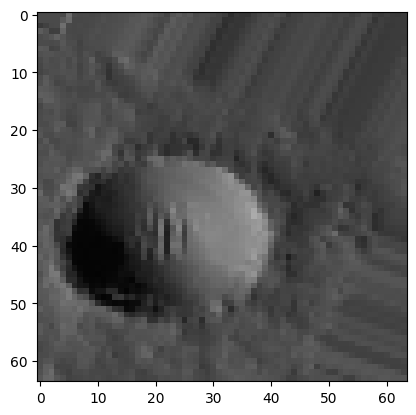

In [40]:
resize = 64
image_test = tf.image.resize(
    train_ds[0][0][0],
    [resize,resize])
print(np.argmax(train_ds[0][1][0]))
plt.imshow(image_test)

In [41]:
BatchSize       = batchsize
Nepochs         = 300
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8, activation='softmax'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")

loss_fn = keras.losses.CategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

'''tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint1_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)'''

model.build(input_shape) # in week 4 CNN.ipynb Abbey didn't have model.build but her summary works, how?
model.summary()

#history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])
history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs)

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Leaky relu parameter =  0.1
BatchSize            =  64
Nepochs              =  300 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (0, 64, 64, 3)            0         
                                                                 
 conv2d_11 (Conv2D)          (0, 64, 64, 64)           1792      
                                                                 
 max_pooling2d_11 (MaxPoolin  (0, 32, 32, 64)          0         
 g2D)                                                            
                                                                

2023-03-12 18:34:08.774520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12/12 [==============================] - 31s 964ms/step - loss: 2.0980 - accuracy: 0.1204 - val_loss: 2.0750 - val_accuracy: 0.1245
Epoch 2/300
12/12 [==============================] - 18s 2s/step - loss: 2.0708 - accuracy: 0.1258 - val_loss: 2.0670 - val_accuracy: 0.1286
Epoch 3/300
12/12 [==============================] - 10s 915ms/step - loss: 2.0654 - accuracy: 0.1854 - val_loss: 2.0415 - val_accuracy: 0.1840
Epoch 4/300
12/12 [==============================] - 32s 2s/step - loss: 2.0461 - accuracy: 0.2233 - val_loss: 2.0208 - val_accuracy: 0.1759
Epoch 5/300
12/12 [==============================] - 65s 5s/step - loss: 2.0162 - accuracy: 0.2084 - val_loss: 1.9689 - val_accuracy: 0.1719
Epoch 6/300
12/12 [==============================] - 21s 2s/step - loss: 1.9063 - accuracy: 0.2179 - val_loss: 1.8631 - val_accuracy: 0.1881
Epoch 7/300
12/12 [==============================] - 74s 4s/step - loss: 1.8906 - accuracy: 0.2260 - val_loss: 1.8721 - val_accuracy: 0.1881
Epoch 8/300
12/12 [

In [42]:
#latest = tf.train.latest_checkpoint(checkpoint_dir)
#model.load_weights(latest) -
loss, acc = model.evaluate(test_ds)

6/6 [==============================] - 2s 387ms/step - loss: 1.0713 - accuracy: 0.7459


history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  300
  accuracy (train) =  [0.1204330176115036, 0.12584573030471802, 0.18538565933704376, 0.22327469289302826, 0.20838971436023712, 0.21786198019981384, 0.22598105669021606, 0.23545332252979279, 0.24763193726539612, 0.25710418820381165, 0.25439783930778503, 0.24627874791622162, 0.243572399020195, 0.24627874791622162, 0.26116374135017395, 0.2746955454349518, 0.26928281784057617, 0.2841677963733673, 0.29905277490615845, 0.26387009024620056, 0.2814614474773407, 0.29905277490615845, 0.33017590641975403, 0.2855209708213806, 0.311231404542923, 0.33017590641975403, 0.30581867694854736, 0.3220568299293518, 0.3139377534389496, 0.33964818716049194, 0.34506088495254517, 0.3152909278869629, 0.34506088495254517, 0.3626522421836853, 0.3288227319717407, 0.33423545956611633, 0.3572395145893097, 0.38430312275886536, 0.391069024801254

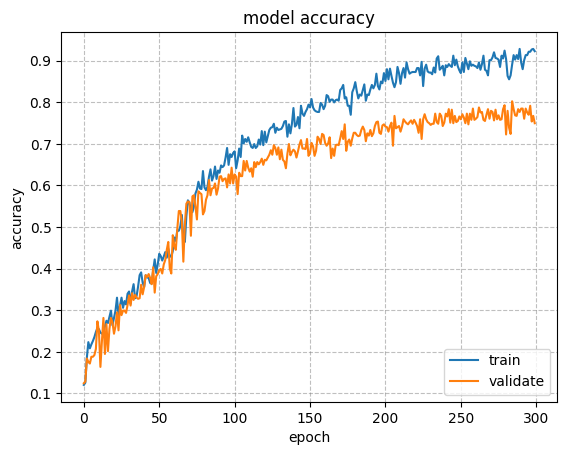

In [43]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')


Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  300
  loss (train)     =  [2.0980308055877686, 2.0708210468292236, 2.0653810501098633, 2.0460667610168457, 2.016209363937378, 1.9062861204147339, 1.8905863761901855, 1.8751755952835083, 1.8604214191436768, 1.8641932010650635, 1.8654156923294067, 1.8279443979263306, 1.8406546115875244, 1.8233909606933594, 1.8256086111068726, 1.7810062170028687, 1.7705785036087036, 1.7590078115463257, 1.7339425086975098, 1.7679802179336548, 1.7365732192993164, 1.6991989612579346, 1.7033613920211792, 1.6910113096237183, 1.678516149520874, 1.6761666536331177, 1.7248834371566772, 1.7148348093032837, 1.6823065280914307, 1.6674834489822388, 1.6392946243286133, 1.67062246799469, 1.630448341369629, 1.6486406326293945, 1.6544203758239746, 1.6283345222473145, 1.6110560894012451, 1.5716063976287842, 1.5734025239944458, 1.582918643951416, 1.593724012374878, 1.5731936693191528, 1.5930951833724976, 1.5485666990280151, 1.56589

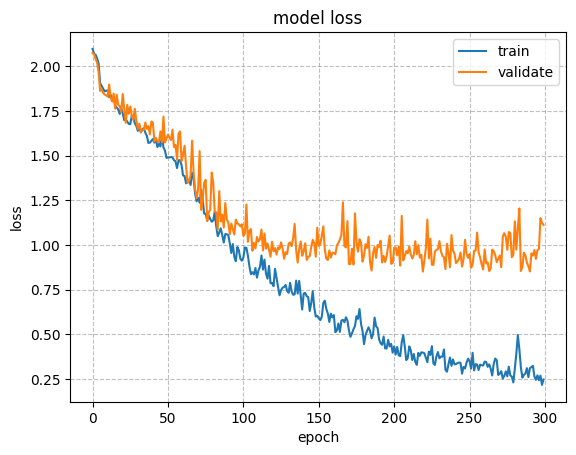

In [44]:
# summarize history for loss
print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
print("  loss (test)      = ", history.history['val_loss'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [45]:
predictions = model.predict(test_ds)

6/6 [==============================] - 2s 329ms/step


In [46]:
import csv

# Create an empty dictionary to store the data
data_dict = {}

with open('landmarks_map-proj-v3_classmap.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Get the number and word values from the current row
        num = int(row[0])
        word = row[1]
        # Add the values to the dictionary
        data_dict[num] = word

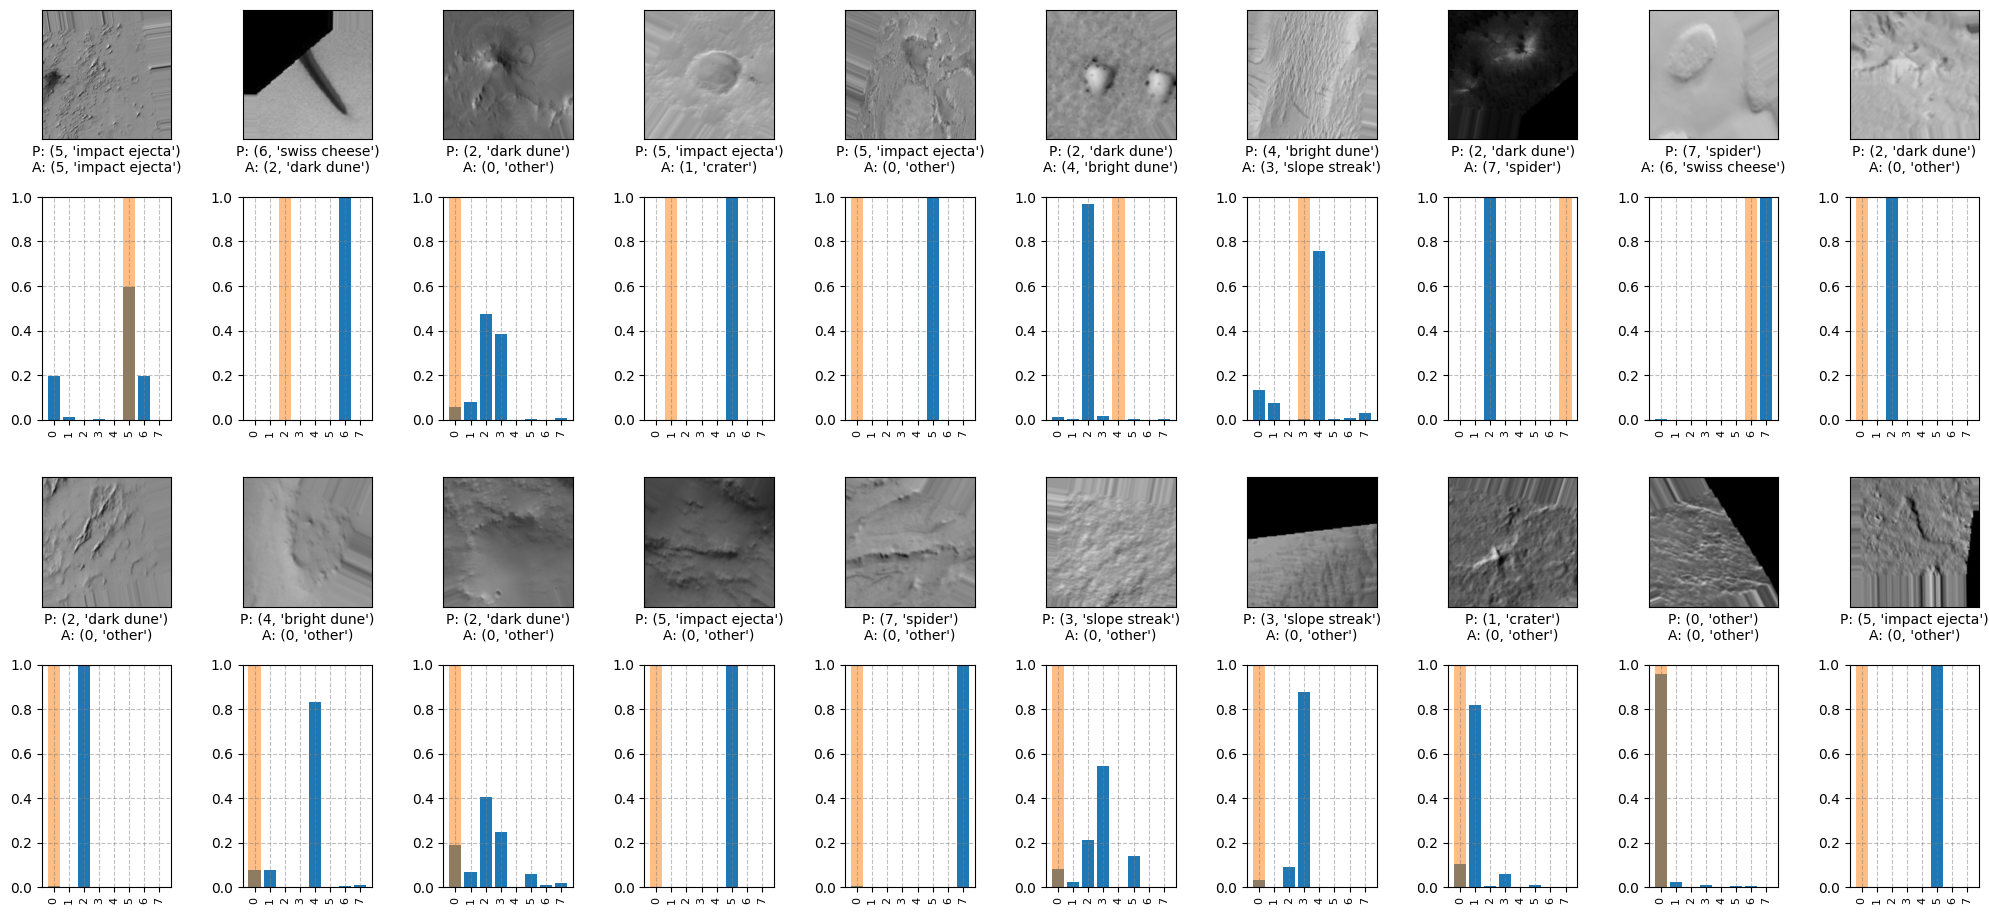

In [47]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(25, 12))
class_list = [i for i in range(0,8)]

rand_list = list(randint(0,1,12))
for i in rand_list:
    class_list.append(i)
count = 0
j = 0
x,y = 0,1
image_count = 0
for i in test_ds:
    image_count = 0
    for k in i[1]:
        prediction = predictions[count]
        actual = np.argmax(k)
        if np.isin(actual,class_list):

            axes[x][j].imshow(i[0][image_count])
            axes[x][j].set_xticks([])
            axes[x][j].set_yticks([])

            # Set the x axis label
            axes[x][j].set_xlabel(f"P: {np.argmax(prediction),data_dict[int(np.argmax(prediction))]}\nA: {actual, data_dict[actual]}",fontsize=10)

            # Add some space between subplots
            plt.subplots_adjust(wspace=0.55)
            plt.subplots_adjust(hspace=0.05)

            # Plot the predicted probabilities as a bar graph
            axes[y][j].bar([0,1,2,3,4,5,6,7],prediction)
            axes[y][j].bar([0,1,2,3,4,5,6,7],k,alpha=0.5)
            axes[y][j].grid(alpha=0.5, linestyle='--', color='gray')
            axes[y][j].set_ylim(0,1)
            axes[y][j].set_xticks([0,1,2,3,4,5,6,7])
            axes[y][j].set_xticklabels([0,1,2,3,4,5,6,7], rotation=90, fontsize=8)

            class_list.remove(int(actual))

            j += 1
    
        image_count += 1
        count += 1

        if len(class_list) == 10:
            x,y,j=2,3,0
        if class_list == []:
            break
    if class_list == []:
        break

In [48]:
abs_predictions = np.argmax(predictions,axis=1)
test_df['models class'] = abs_predictions
test_df.head(20)
print(len(abs_predictions))

370


[6.976744186046512, 17.391304347826086, 15.0, 14.814814814814813, 6.382978723404255, 24.528301886792452, 9.25925925925926, 9.090909090909092]


Text(0, 0.5, 'prediction accuracy percentage')

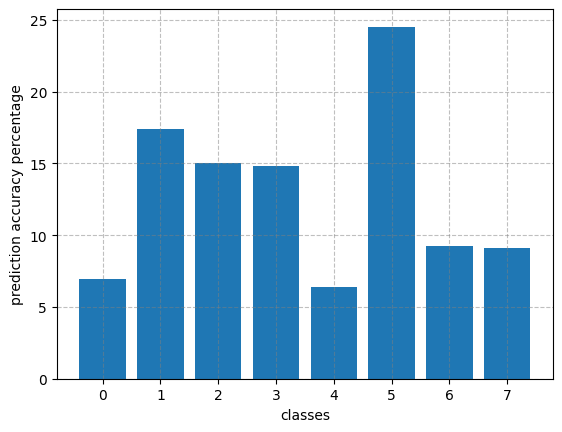

In [49]:
# for some reason class was a column of strings... took ages to figure that out
test_df['class'] = test_df['class'].astype(int)
class_list = [i for i in range(0,8)]

accuracy_list = []
for i in class_list:
    
    df_0 = test_df.loc[test_df['class'] == i]
    num_identical = sum(df_0['class'] == df_0['models class'])
    num_rows = len(df_0)
    percent_identical = num_identical / num_rows * 100
    accuracy_list.append(percent_identical)

print(accuracy_list)
plt.bar(class_list,accuracy_list)
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.xlabel('classes')
plt.ylabel('prediction accuracy percentage')

### changing to is/is not:[dune]

In [50]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

# Replace non-dune class labels with 0 & again with the string values for class. whyyyyyyyyyyy
print('reformatting')
df['class'] = df['class'].astype(int)
df.loc[~df['class'].isin([2, 4]), 'class'] = 0
df.loc[df['class'].isin([2, 4]), 'class']  = 1
df['class'] = df['class'].astype(str)

clist = [0,1]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(f'length of class: {i}',len(df[df['class']==str(i)]))
print('min class count',np.min(num_class))

for i in clist:
    df_other = df[df['class']==str(i)].sample(n=np.min(num_class), random_state=1)
    df = df.drop(df.index[(df["class"] == str(i))])
    df = pd.concat([df_other,df])
    
clist = [0,1]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(f'length of class: {i}',len(df[df['class']==str(i)]))

image classes
dataframe
shuffling
reformatting
length of class: 0 70140
length of class: 1 2891
min class count 2891
length of class: 0 2891
length of class: 1 2891


In [51]:
print('traintestsplit')
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize=128

print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

traintestsplit
image generator
batching
Found 2312 validated image filenames belonging to 2 classes.
Found 1157 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.


In [52]:
BatchSize       = batchsize
Nepochs         = 30
resize = 128
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(16, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.10))

model.add(keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.15))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(2, activation='sigmoid'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint2_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) 
model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  30 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (0, 128, 128, 3)          0         
                                                                 
 conv2d_15 (Conv2D)          (0, 128, 128, 16)         448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (0, 64, 64, 16)          0         
 g2D)                                                            
                                    

2023-03-12 20:25:47.623812: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


19/19 [==============================] - ETA: 0s - loss: 0.7725 - accuracy: 0.5004
Epoch 1: saving model to binary_model_weights_home/cp-0001.ckpt
19/19 [==============================] - 13s 664ms/step - loss: 0.7725 - accuracy: 0.5004 - val_loss: 0.6930 - val_accuracy: 0.5058
Epoch 2/30
18/19 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5055
Epoch 2: saving model to binary_model_weights_home/cp-0002.ckpt
19/19 [==============================] - 13s 691ms/step - loss: 0.6928 - accuracy: 0.5082 - val_loss: 0.6922 - val_accuracy: 0.4449
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.5078
Epoch 3: saving model to binary_model_weights_home/cp-0003.ckpt
19/19 [==============================] - 7s 387ms/step - loss: 0.6881 - accuracy: 0.5078 - val_loss: 0.6783 - val_accuracy: 0.4976
Epoch 4/30
18/19 [===========================>..] - ETA: 0s - loss: 0.6632 - accuracy: 0.5426
Epoch 4: saving model to binary_model_weights_ho

history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  30
  accuracy (train) =  [0.500432550907135, 0.508217990398407, 0.507785439491272, 0.5436851382255554, 0.6025086641311646, 0.6016436219215393, 0.599913477897644, 0.6557093262672424, 0.6379757523536682, 0.6682525873184204, 0.6877162456512451, 0.6353806257247925, 0.6807958483695984, 0.6976643800735474, 0.7123702168464661, 0.737456738948822, 0.7474048733711243, 0.753892719745636, 0.7759515643119812, 0.8066608905792236, 0.8278546929359436, 0.8291522264480591, 0.8442906737327576, 0.8490484356880188, 0.8615916967391968, 0.8637543320655823, 0.867214560508728, 0.8607266545295715, 0.8689446449279785, 0.8910034894943237]
  accuracy (test)  =  [0.505836546421051, 0.4448767900466919, 0.49762213230133057, 0.5620406270027161, 0.5633376836776733, 0.5983571410179138, 0.6104626059532166, 0.6982274055480957, 0.6376999616622925, 0.663

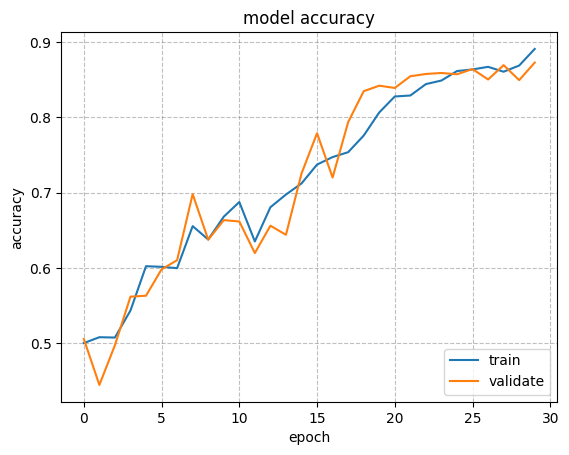

In [53]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')


Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  30
  loss (train)     =  [0.7724800109863281, 0.6928321719169617, 0.6880577802658081, 0.6612023115158081, 0.6524962186813354, 0.658049464225769, 0.6478028297424316, 0.6401110887527466, 0.6262256503105164, 0.6199295520782471, 0.5999584197998047, 0.638214647769928, 0.594770073890686, 0.5772529244422913, 0.5633254647254944, 0.5356240272521973, 0.5142351984977722, 0.5174742937088013, 0.48771360516548157, 0.4388429820537567, 0.39324384927749634, 0.39927130937576294, 0.3707978129386902, 0.369531512260437, 0.3604665994644165, 0.34741026163101196, 0.33525827527046204, 0.35312899947166443, 0.31270352005958557, 0.29686424136161804]


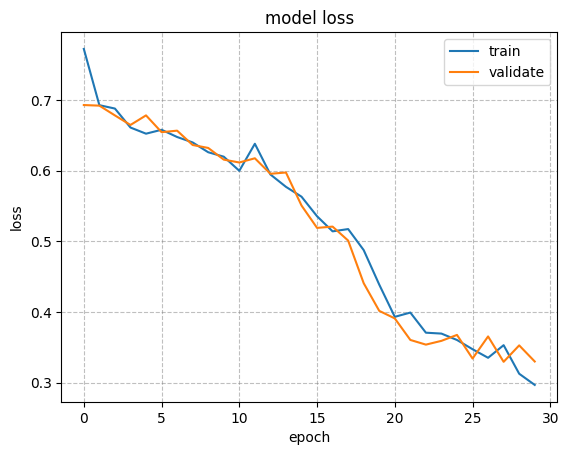

In [54]:
print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [55]:
old_predictions = model.predict(test_ds)

10/10 [==============================] - 1s 82ms/step


In [58]:
predictions = []
for i in old_predictions:
    predictions.append(i[0])
print(predictions)

[0.12904698, 0.00010689398, 0.70884717, 0.9820233, 0.93972635, 0.994313, 0.18250862, 0.96570164, 0.08937284, 0.03860392, 0.006795729, 0.005946631, 0.7030784, 0.83214986, 0.19785985, 0.9271856, 0.3823268, 0.009685224, 0.88956076, 0.21738212, 0.52866614, 0.34409478, 0.924455, 0.97001845, 0.9472194, 0.9896618, 0.9893532, 0.6217537, 0.008364444, 0.74293137, 0.18303621, 0.74960583, 0.178771, 0.9697314, 0.999246, 0.9660817, 0.9641432, 0.01576203, 0.7396906, 0.017593531, 0.016220849, 0.036471706, 0.9513073, 0.015731942, 0.70562315, 0.52538514, 0.03743318, 0.9185365, 0.50266916, 0.36007276, 0.0031585565, 0.1535787, 0.995567, 0.9559297, 0.97676474, 0.36850622, 0.9125912, 0.8521769, 0.9230099, 0.99540496, 0.96624136, 0.98113865, 0.1783608, 0.15219425, 0.38445458, 0.97808814, 0.98200065, 0.18230645, 0.96551317, 0.75586516, 0.93876153, 0.892883, 0.8467546, 0.056904726, 0.2251614, 0.98319525, 0.9858386, 0.037206035, 0.96408933, 0.93186796, 0.8436885, 0.688753, 0.34614474, 0.0012465424, 0.6800734, 0

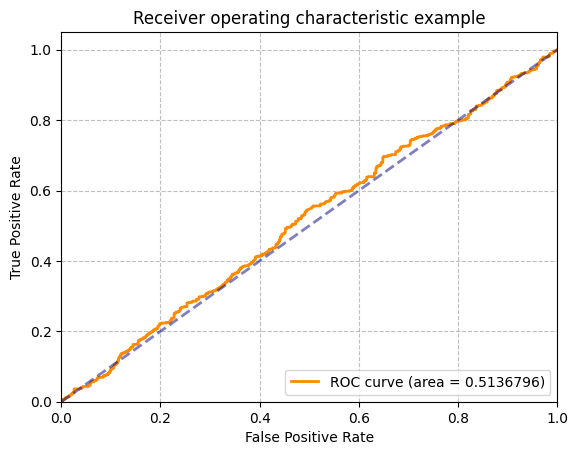

In [61]:
fpr, tpr, _ = roc_curve(test_ds.classes, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.7f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',alpha = 0.5)
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()